In [69]:
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from cleaner import *
import re
import string
from string import punctuation
from random import shuffle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import time
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
import gensim
from gensim.models.word2vec import Word2Vec 
LabeledSentence = gensim.models.doc2vec.LabeledSentence 
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [70]:
df = pd.read_csv('data/final_data.csv')
df.shape

(93170, 13)

In [71]:
df = df[pd.notnull(df['Tweet'])]

In [72]:
col = ['Category', 'Tweet']
df = df[col]

In [73]:
df.columns = ['Category', 'Tweet']

In [74]:
def clean_text_round1(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [75]:
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical 
    text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

In [76]:
from generator import*
data_xml=[]

stop_words = ['ourselves', 'hers', 'between', 'yourself', 
              'but', 'again', 'there', 'about', 'once', 
              'during', 'out', 'very', 'with', 'they',
              'own', 'an', 'be', 'some', 'for', 'do', 'its', 
              'yours', 'such', 'into', 'of', 'most', 'itself',
              'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 
              'from', 'him', 'each', 'the', 'themselves', 'until', 
              'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don',
              'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 
              'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 
              'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 
              'been', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because',
              'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you',
              'herself', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after',
              'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 
              'how', 'further', 'was', 'here', 'than']

def tokenize(tweet):
    tweet = nlp(tweet)
    tweet = negation_tag(tweet)
    tweet = ' '.join(tweet)
    tweet=clean_text_round1(tweet)
    tweet=clean_text_round2(tweet)
    tokens = tokenizer.tokenize(tweet.lower())
    tokens=[w for w in tokens if not w in stop_words]
    
    try:
        temp=[]
        tokens = list(filter(lambda t: not t.startswith('@'), tokens))
        tokens = list(filter(lambda t: not t.startswith('#'), tokens))
        tokens = list(filter(lambda t: not t.startswith('http'), tokens))
        tokens = list(filter(lambda t: not t.startswith('www'), tokens))
        temp.append(tokens)
        #print(type(data.Category.values))
        #temp.append(data.Category)
        data_xml.append(temp)
        

        
        #doc=convert_to_doc(' '.join(tokens))
        #data_xml.append(doc)
        #vector=generator_vec(doc)
        return tokens
    except:
        return 'NC'

In [77]:
def postprocess(data, n=93170):
    data = data.head(n)
    data['tokens'] = data['Tweet'].progress_map(tokenize) 
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    return data

data = postprocess(df)

progress-bar: 100%|██████████| 93170/93170 [15:26<00:00, 100.56it/s]


In [78]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data.head(93170).tokens),
                                   np.array(data.head(93170).Tweet), test_size=0.2)

In [79]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

74536it [00:00, 138292.92it/s]
18634it [00:00, 203675.12it/s]


In [80]:
tweet_w2v = Word2Vec(size=150, min_count=20,sg=0)#sg=1: skip-gram, 0: cbow
tweet_w2v.build_vocab([x.words for x in tqdm(x_train)])
tweet_w2v.train([x.words for x in tqdm(x_train)], 
                total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.iter)

100%|██████████| 74536/74536 [00:00<00:00, 1407264.59it/s]


(2139031, 3204745)

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.decomposition import PCA

def plot_words(words):
    word_vecs = [tweet_w2v[word] for word in words]
    pca = PCA(n_components=2)

    columns = ["Component1","Component2"]
    df = pd.DataFrame(pca.fit_transform(word_vecs), columns=columns, index=words)
    def annotate_df(row):  
        ax.annotate(row.name, list(row.values),
                    xytext=(10,-5), 
                    textcoords='offset points',
                    size=12, 
                    color='black')

    ax = df.plot(kind="scatter",x='Component1', y='Component2',)
    _ = df.apply(annotate_df, axis=1)
    plt.savefig('outputcb.jpg')
    

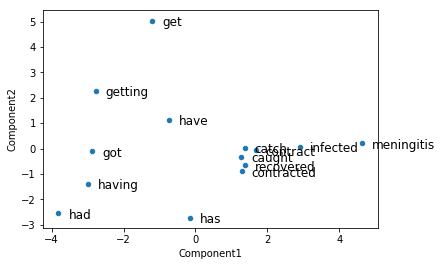

In [82]:
words=['meningitis','contracted', 
       'contract',
       'get', 'got',
       'getting',
       'have', 'having', 'had', 'has', 'catch', 'caught', 'infected', 'recovered']

plot_words(words)

In [83]:
print('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=0)
matrix = vectorizer.fit_transform([x.words for x in x_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 24368


In [84]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [85]:
data['category_id'] = data['Category'].factorize()[0]
from io import StringIO
category_id_df = data[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

In [86]:
labels=data.category_id

In [88]:
from sklearn.preprocessing import scale
features = np.concatenate([buildWordVector(z, 150) for z in tqdm(map(lambda x: x, data.tokens))])
features = scale(features)




0it [00:00, ?it/s]
648it [00:00, 6473.06it/s]
1286it [00:00, 6443.12it/s]
1933it [00:00, 6448.40it/s]
2600it [00:00, 6512.12it/s]
3329it [00:00, 6726.56it/s]
4003it [00:00, 6729.64it/s]
4709it [00:00, 6824.37it/s]
5407it [00:00, 6868.50it/s]
6072it [00:00, 6798.98it/s]
6770it [00:01, 6851.10it/s]
7505it [00:01, 6991.89it/s]
8197it [00:01, 6968.15it/s]
8886it [00:01, 6943.74it/s]
9613it [00:01, 7037.34it/s]
10314it [00:01, 6996.01it/s]
11100it [00:01, 7233.33it/s]
11824it [00:01, 6989.90it/s]
12554it [00:01, 7078.79it/s]
13264it [00:01, 6965.75it/s]
13963it [00:02, 6876.96it/s]
14664it [00:02, 6915.15it/s]
15380it [00:02, 6985.74it/s]
16163it [00:02, 7218.76it/s]
16888it [00:02, 7155.62it/s]
17650it [00:02, 7288.69it/s]
18381it [00:02, 7286.23it/s]
19111it [00:02, 7171.64it/s]
19895it [00:02, 7359.45it/s]
20634it [00:02, 7181.26it/s]
21355it [00:03, 7091.94it/s]
22067it [00:03, 7030.28it/s]
22774it [00:03, 7041.19it/s]
23541it [00:03, 7218.64it/s]
24288it [00:03, 7291.65it/s]
25019it [

# Vectorizing the tweet using the embedding model

In [90]:
start = time.time()

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MLPClassifier(),
    #MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
print("Execution time =  {}".format(time.time()-start))

Execution time =  1107.3146092891693


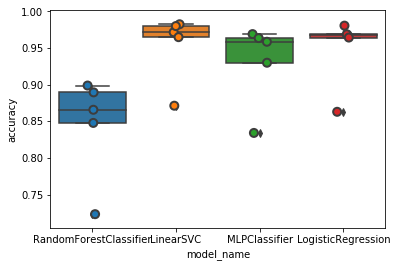

In [91]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
#plt.show()
plt.savefig('plot/word2Vec/models.jpg')

In [92]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.953878
LogisticRegression        0.948758
MLPClassifier             0.930909
RandomForestClassifier    0.844925
Name: accuracy, dtype: float64

## Support Vector Machine

In [93]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

   Infection       0.95      0.99      0.97      9122
     Concern       0.00      0.00      0.00       294
     Vaccine       0.99      0.99      0.99      9258
    Campaign       0.99      0.99      0.99      3340
        News       0.99      0.98      0.98      8733

   micro avg       0.98      0.98      0.98     30747
   macro avg       0.78      0.79      0.79     30747
weighted avg       0.97      0.98      0.97     30747



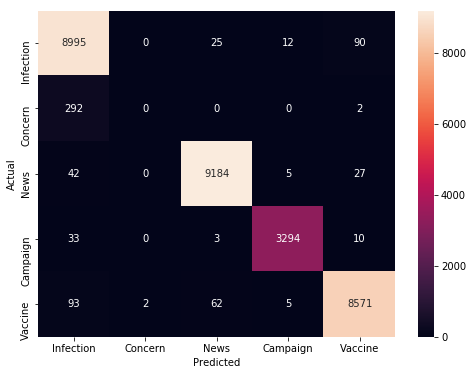

In [96]:
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y_test, y_pred)

target_names=['Infection','Concern','Vaccine','Campaign','News']
print(classification_report(y_test, y_pred, target_names=target_names))


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('plot/word2Vec/svm.jpg')
plt.show()

## ANN

In [97]:
model_ann = MLPClassifier()
model_ann.fit(X_train, y_train)
y_pred = model_ann.predict(X_test)

              precision    recall  f1-score   support

   Infection       0.96      0.97      0.97      9122
     Concern       0.31      0.27      0.29       294
     Vaccine       0.99      0.99      0.99      9258
    Campaign       0.99      0.99      0.99      3340
        News       0.99      0.99      0.99      8733

   micro avg       0.98      0.98      0.98     30747
   macro avg       0.85      0.84      0.85     30747
weighted avg       0.98      0.98      0.98     30747



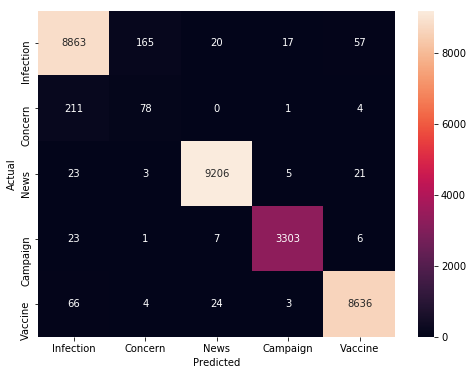

In [98]:
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y_test, y_pred)

target_names=['Infection','Concern','Vaccine','Campaign','News']
print(classification_report(y_test, y_pred, target_names=target_names))

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('plot/word2Vec/ann.jpg')
plt.show()

## Random Forest

In [99]:
model_rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

              precision    recall  f1-score   support

   Infection       0.82      0.90      0.86      9122
     Concern       0.00      0.00      0.00       294
     Vaccine       0.93      0.91      0.92      9258
    Campaign       0.95      0.76      0.85      3340
        News       0.84      0.86      0.85      8733

   micro avg       0.87      0.87      0.87     30747
   macro avg       0.71      0.69      0.70     30747
weighted avg       0.87      0.87      0.87     30747



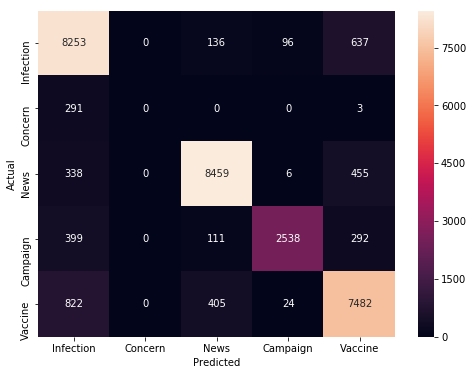

In [100]:
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y_test, y_pred)

target_names=['Infection','Concern','Vaccine','Campaign','News']
print(classification_report(y_test, y_pred, target_names=target_names))

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('plot/word2Vec/rf.jpg')
plt.show()

## Logistic Regression

In [101]:
model_lr =  LogisticRegression(random_state=0)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

              precision    recall  f1-score   support

   Infection       0.95      0.98      0.97      9122
     Concern       0.00      0.00      0.00       294
     Vaccine       0.99      0.99      0.99      9258
    Campaign       0.99      0.98      0.99      3340
        News       0.98      0.98      0.98      8733

   micro avg       0.97      0.97      0.97     30747
   macro avg       0.78      0.79      0.78     30747
weighted avg       0.97      0.97      0.97     30747



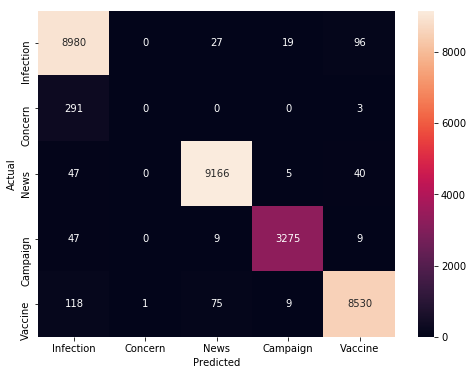

In [102]:
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y_test, y_pred)

target_names=['Infection','Concern','Vaccine','Campaign','News']
print(classification_report(y_test, y_pred, target_names=target_names))

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('plot/word2Vec/lr.jpg')
plt.show()